In [422]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from prometheus_api_client import *
from prometheus_api_client import PrometheusConnect
from prometheus_api_client.utils import parse_datetime
import matplotlib.pyplot as plt
from merlion.utils import TimeSeries, UnivariateTimeSeries
from merlion.evaluate.anomaly import TSADMetric

def evaluateModel(ground_truth, predict):
    p = TSADMetric.Precision.value(ground_truth=ground_truth, predict=predict)
    r = TSADMetric.Recall.value(ground_truth=ground_truth, predict=predict)
    f1 = TSADMetric.F1.value(ground_truth=ground_truth, predict=predict)
    mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=ground_truth, predict=predict)
    print(f"Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}\n"
       f"Mean Time To Detect: {mttd}")

# Using NAB datasets

## Real known cause anomaly data

In [308]:
from ts_datasets.anomaly import NAB
from ts_datasets import anomaly
from merlion.plot import plot_anoms

In [309]:
# This is a time series with anomalies in both the train and test split.
# time_series and metadata are both time-indexed pandas DataFrames.
time_series, metadata = NAB(subset="realKnownCause")[3]

from merlion.utils import TimeSeries

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

Time series /Users/I853328/Desktop/Merlion/data/nab/realKnownCause/ec2_request_latency_system_failure.csv (index 2) has timestamp duplicates. Kept first values.
Time series /Users/I853328/Desktop/Merlion/data/nab/realKnownCause/machine_temperature_system_failure.csv (index 3) has timestamp duplicates. Kept first values.


### SKlearn Isolation Tree without data preprocess

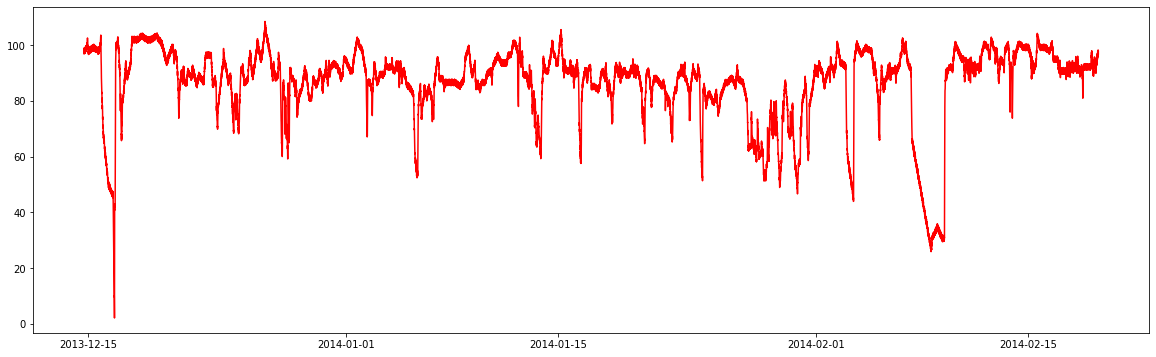

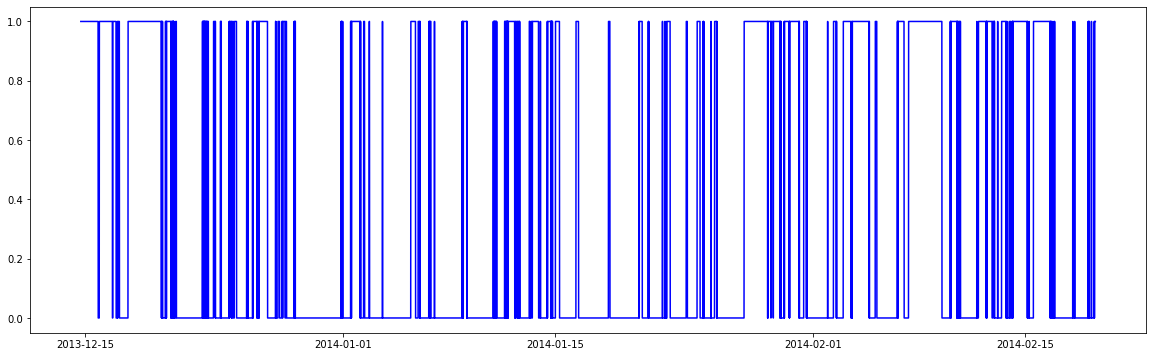

In [310]:
from sklearn.ensemble import IsolationForest

# different contamination means different decision_function values, while same score_samples
# decision_function = score_samples - offset_, offset is relevant with contamination
# When the contamination parameter is set to “auto”, the offset is equal to -0.5
# as the scores of inliers are close to 0 and the scores of outliers are close to -1.

outlier_fraction = 'auto'

clf = IsolationForest(n_estimators=100, max_samples="auto", random_state=0, contamination=outlier_fraction)

clf.fit(train_data.to_pd()['value'].values.reshape(len(train_data),1))

result = clf.predict(test_data.to_pd()['value'].values.reshape(len(test_data),1))
result = pd.DataFrame( { 'anomaly' : [ 0. if i==1 else 1. for i in list(result) ], 
                        }, index = test_data.to_pd().index)

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, result, 'b')

In [311]:
from merlion.evaluate.anomaly import TSADMetric
p = TSADMetric.Precision.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
r = TSADMetric.Recall.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
f1 = TSADMetric.F1.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
print(f"Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}\n"
       f"Mean Time To Detect: {mttd}")

Precision: 0.0005, Recall: 1.0000, F1: 0.0011
Mean Time To Detect: 0 days 00:00:00


### Custom Label Function

In [316]:
train_scores = -clf.score_samples(train_data.to_pd()['value'].values.reshape(len(train_data),1))
times = train_data.to_pd().index
train_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, train_scores)})

test_scores = -clf.score_samples(test_data.to_pd()['value'].values.reshape(len(test_data),1))
times = test_data.to_pd().index
test_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, test_scores)})


In [317]:
from merlion.post_process.calibrate import AnomScoreCalibrator

max_score = 1.0
calibrator = AnomScoreCalibrator(max_score=max_score)
calibrator.train(anomaly_scores=train_scores)
train_scores_after_calibrator = calibrator(train_scores)
test_scores_after_calibrator = calibrator(test_scores)

calibrator

AnomScoreCalibrator(abs_score=True, anchors=[(0.4360499011406043, 0.0), (0.46666806700454805, 0.5), (0.5185929646677796, 1.0), (0.5617242285935276, 1.5), (0.6021634124587338, 2.0), (0.7023454286065524, 4.032967313158118), (1.0, 5.032967313158118)], max_score=1.0)

In [318]:
from merlion.post_process.threshold import AggregateAlarms

custom_threshold = AggregateAlarms(alm_threshold=3, 
                                   abs_score=True,
                                   min_alm_in_window = 0,
                                   alm_window_minutes = 1,
                                   alm_suppress_minutes = 0)
custom_threshold.train(anomaly_scores=train_scores_after_calibrator)
test_scores_after_aggregate = custom_threshold(test_scores_after_calibrator)

custom_threshold

AggregateAlarms(abs_score=True, alm_suppress_minutes=0, alm_threshold=3, alm_window_minutes=1, min_alm_in_window=0)

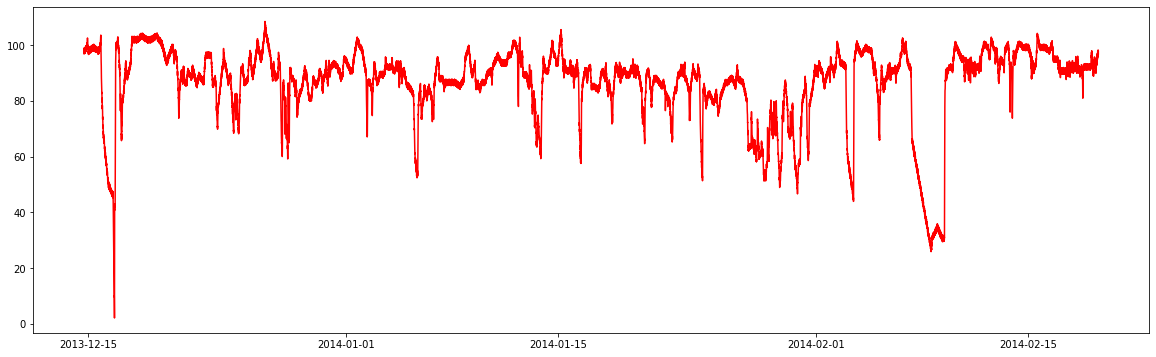

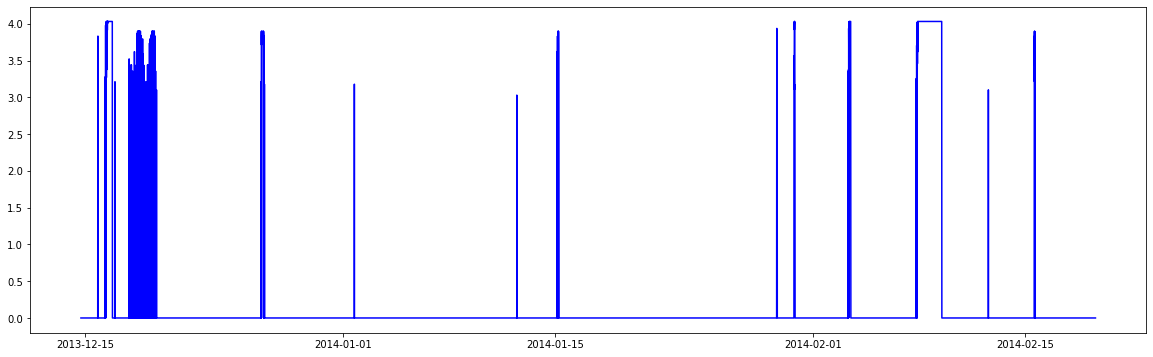

In [319]:
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_scores_after_aggregate.to_pd(), 'b')


In [320]:
evaluateModel(test_labels, test_scores_after_aggregate)

Precision: 0.0061, Recall: 0.6667, F1: 0.0121
Mean Time To Detect: 0 days 03:07:30


### Isolation Tree with data preprocess (use some functions from SalesForce Merlion)

In [256]:
from merlion.transform.moving_average import DifferenceTransform
from merlion.transform.sequence import TransformSequence
from merlion.transform.resample import Shingle
from sklearn.ensemble import IsolationForest
from merlion.utils import UnivariateTimeSeries, TimeSeries

_default_transform = TransformSequence([DifferenceTransform(), Shingle(size=2, stride=1)])

#_default_transform = TransformSequence([Shingle(size=2, stride=1)])

_default_transform.train(train_data)

#train_data needs to transform
train_data_ = _default_transform(train_data)

outlier_fraction = 'auto'

times, train_values = zip(*train_data_.align())
train_values = np.asarray(train_values)

clf = IsolationForest(n_estimators=100, max_samples="auto", random_state=0, contamination=outlier_fraction)
clf.fit(train_values)

IsolationForest(random_state=0)

In [257]:
train_scores = -clf.score_samples(train_values)
times, train_values = zip(*train_data_.align())
train_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, train_scores)})

test_data_ = _default_transform(test_data)
times_test, test_values = zip(*test_data_.align())
test_values = np.asarray(test_values)

test_scores = -clf.score_samples(test_values)

times, test_values = zip(*test_data_.align())
test_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, test_scores)})

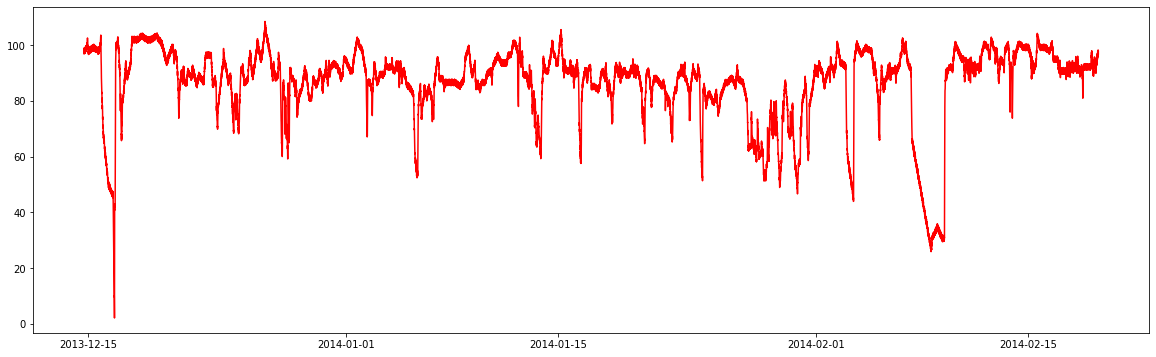

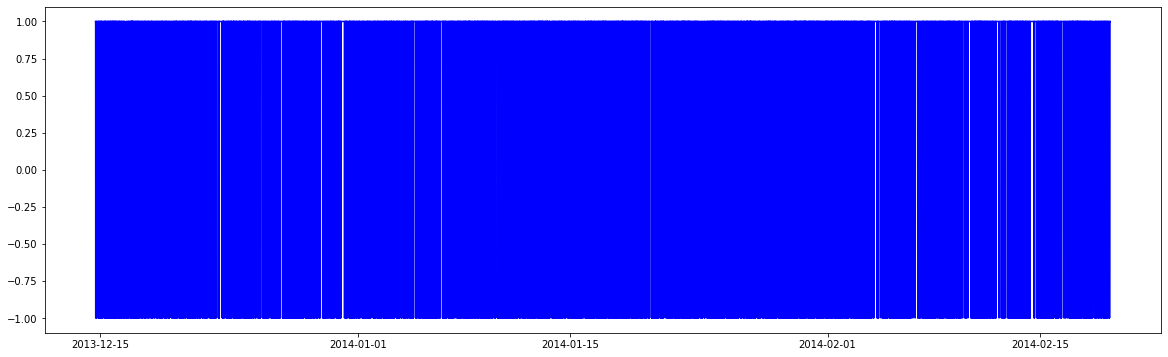

In [258]:
# if without custom label function, the labels would be very annoying
result = clf.predict(test_values)
result

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
# if DifferenceTransform is enabled in preprocess
plt.plot(test_data.to_pd().index[1:], result, 'b')
# if DifferenceTransform is not enabled in preprocess
#plt.plot(test_data.to_pd().index, result, 'b')

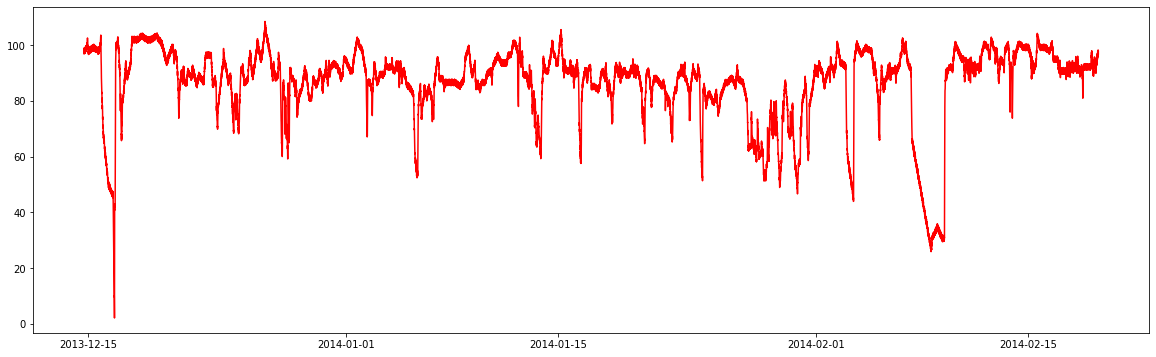

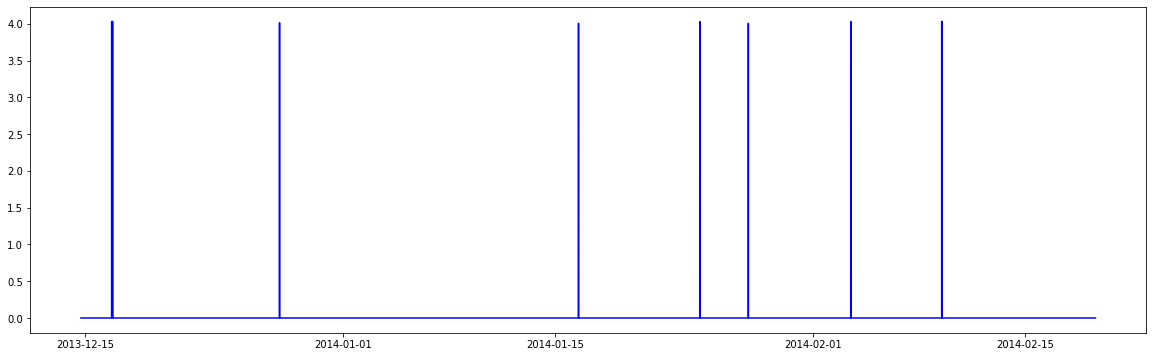

In [278]:
# with labels being aggregated, the results would be look more clean
from merlion.post_process.calibrate import AnomScoreCalibrator
from merlion.post_process.threshold import AggregateAlarms

max_score = 1.0
calibrator = AnomScoreCalibrator(max_score=max_score)
calibrator.train(anomaly_scores=train_scores)
train_scores_after_calibrator = calibrator(train_scores)
test_scores_after_calibrator = calibrator(test_scores)

custom_threshold = AggregateAlarms(alm_threshold=4, 
                                   abs_score=True,
                                   min_alm_in_window = 0,
                                   alm_window_minutes = 10,
                                   alm_suppress_minutes = 10)
custom_threshold.train(anomaly_scores=train_scores_after_calibrator)
test_scores_after_aggregate = custom_threshold(test_scores_after_calibrator)

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
# if DifferenceTransform is enabled in preprocess
plt.plot(test_data.to_pd().index[1:], test_scores_after_aggregate.to_pd(), 'b')
# if DifferenceTransform is not enabled in preprocess
# plt.plot(test_data.to_pd().index, test_scores_after_aggregate.to_pd(), 'b')

In [279]:
evaluateModel(test_labels, test_scores_after_aggregate)

Precision: 0.4286, Recall: 1.0000, F1: 0.6000
Mean Time To Detect: 1 days 00:03:20


### Isolation Tree using SalesForce Merlion

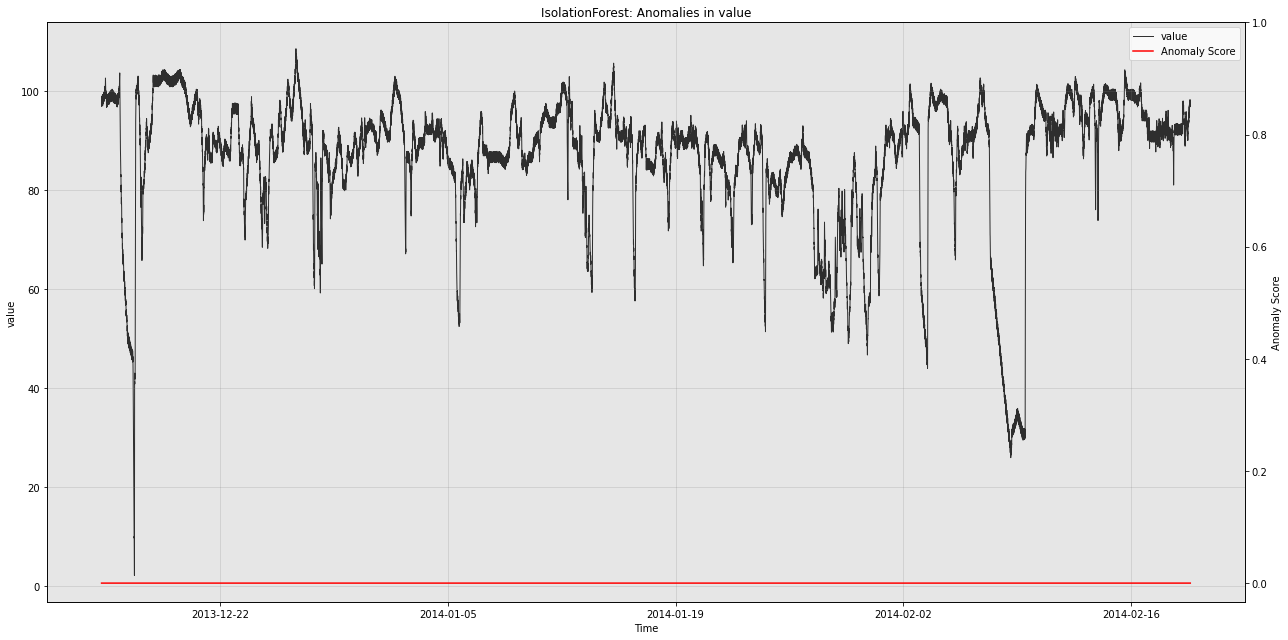

In [267]:
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig
from merlion.post_process.threshold import AggregateAlarms

config = IsolationForestConfig(threshold=AggregateAlarms(alm_threshold=4.5))
model_merlion  = IsolationForest(config)

train_scores_merlion = model_merlion.train(train_data=train_data, anomaly_labels=None)

scores_merlion = model_merlion.get_anomaly_score(test_data)
labels_merlion = model_merlion.get_anomaly_label(test_data)

fig, ax = model_merlion.plot_anomaly(
    time_series=test_data,
    filter_scores=True, 
    plot_time_series_prev=True,
    figsize=(1800,900))

plt.show()
print()


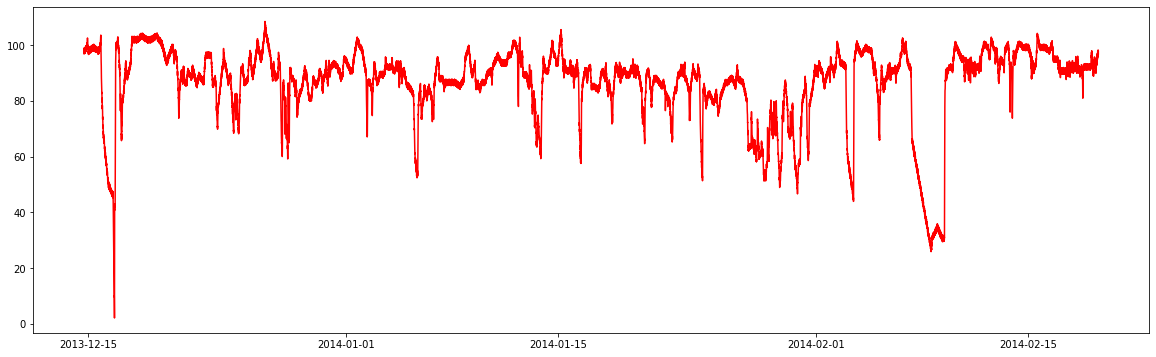

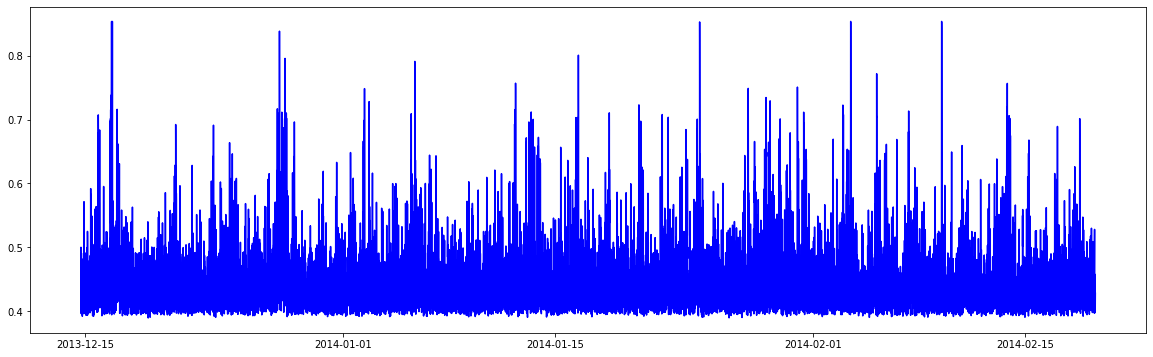

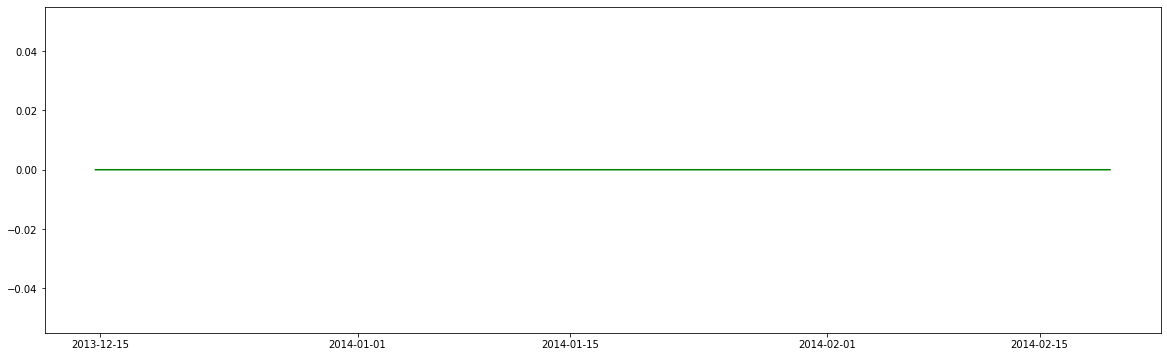

In [54]:
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[1:], scores_merlion.to_pd(), 'b')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[1:], labels_merlion.to_pd(), 'g')

In [55]:
evaluateModel(test_labels, labels_merlion)

Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Mean Time To Detect: 0 days 00:00:00


In [56]:
test_data

                         value
2013-12-14 16:50:00  97.553922
2013-12-14 16:55:00  98.098957
2013-12-14 17:00:00  98.858194
2013-12-14 17:05:00  96.879666
2013-12-14 17:10:00  98.083988
...                        ...
2014-02-19 15:05:00  98.185415
2014-02-19 15:10:00  97.804168
2014-02-19 15:15:00  97.135468
2014-02-19 15:20:00  98.056852
2014-02-19 15:25:00  96.903861

[19280 rows x 1 columns]

In [36]:
scores_merlion


                     anom_score
2013-12-14 16:55:00    0.424103
2013-12-14 17:00:00    0.418938
2013-12-14 17:05:00    0.484891
2013-12-14 17:10:00    0.500257
2013-12-14 17:15:00    0.449213
...                         ...
2014-02-19 15:05:00    0.419456
2014-02-19 15:10:00    0.415807
2014-02-19 15:15:00    0.406724
2014-02-19 15:20:00    0.427094
2014-02-19 15:25:00    0.428348

[19279 rows x 1 columns]

## AWS cloudWatch Data

In [116]:
from sklearn.ensemble import IsolationForest
time_series, metadata = NAB(subset="realAWSCloudwatch")[3]

from merlion.utils import TimeSeries

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

Time series /Users/I853328/Desktop/Merlion/data/nab/realAWSCloudwatch/ec2_disk_write_bytes_1ef3de.csv (index 8) has timestamp duplicates. Kept first values.
Time series /Users/I853328/Desktop/Merlion/data/nab/realAWSCloudwatch/ec2_network_in_5abac7.csv (index 11) has timestamp duplicates. Kept first values.


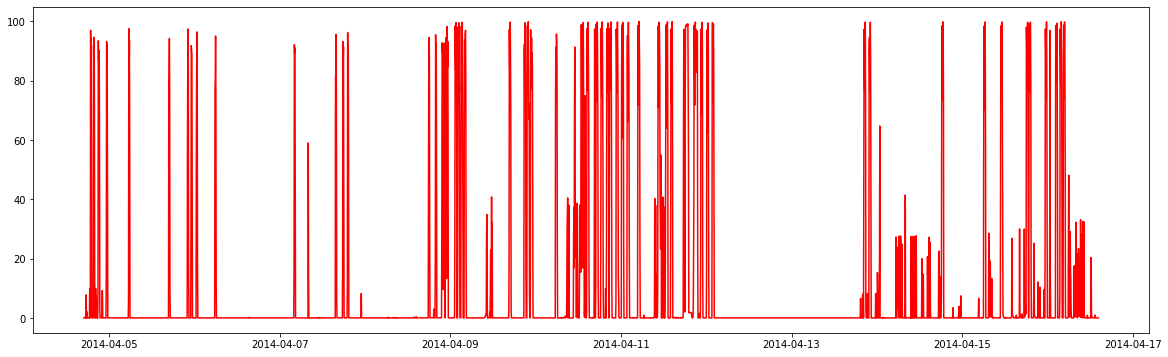

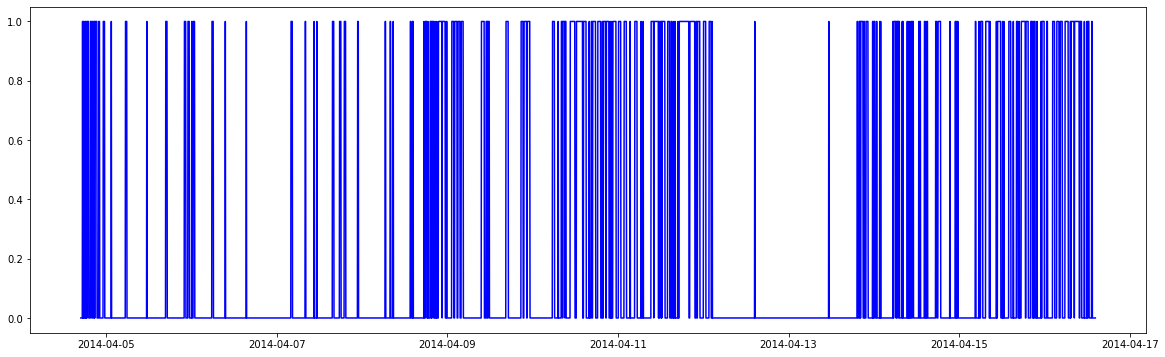

In [121]:
outlier_fraction = 'auto'

clf = IsolationForest(n_estimators=50, max_samples="auto", random_state=0, contamination=outlier_fraction, bootstrap=True,)

clf.fit(train_data.to_pd()['value'].values.reshape(len(train_data),1))

result = clf.predict(test_data.to_pd()['value'].values.reshape(len(test_data),1))
result = pd.DataFrame( { 'anomaly' : [ 0. if i==1 else 1. for i in list(result) ], 
                        }, index = test_data.to_pd().index)
#pd.DataFrameresult= train_data.to_pd().index
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, result, 'b')

In [122]:
from merlion.evaluate.anomaly import TSADMetric
p = TSADMetric.Precision.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
r = TSADMetric.Recall.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
f1 = TSADMetric.F1.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
print(f"Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}\n"
       f"Mean Time To Detect: {mttd}")



Precision: 0.0015, Recall: 1.0000, F1: 0.0031
Mean Time To Detect: 0 days 00:20:00


### Custom label function

In [125]:
train_scores = -clf.score_samples(train_data.to_pd()['value'].values.reshape(len(train_data),1))
times = train_data.to_pd().index
train_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, train_scores)})

test_scores = -clf.score_samples(test_data.to_pd()['value'].values.reshape(len(test_data),1))
times = test_data.to_pd().index
test_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, test_scores)})

In [130]:
from merlion.post_process.calibrate import AnomScoreCalibrator

max_score = 1.0
calibrator = AnomScoreCalibrator(max_score=max_score)
calibrator.train(anomaly_scores=train_scores)
train_scores_after_calibrator = calibrator(train_scores)
test_scores_after_calibrator = calibrator(test_scores)

calibrator

AnomScoreCalibrator(abs_score=True, anchors=[(0.35202761857915027, 0.0), (0.36051541193622016, 0.5), (0.4017612283664195, 1.0), (0.625679670041752, 1.5), (0.6934966800731939, 2.0), (1.0, 5.0)], max_score=1.0)

In [131]:
test_scores_after_calibrator


                     anom_score
2014-04-04 16:50:00    0.500000
2014-04-04 16:55:00    0.000000
2014-04-04 17:00:00    0.920235
2014-04-04 17:05:00    0.500000
2014-04-04 17:10:00    0.000000
...                         ...
2014-04-16 14:00:00    1.000000
2014-04-16 14:05:00    0.500000
2014-04-16 14:10:00    0.500000
2014-04-16 14:15:00    0.000000
2014-04-16 14:20:00    0.500000

[3427 rows x 1 columns]

In [132]:
from merlion.post_process.threshold import AggregateAlarms

custom_threshold = AggregateAlarms(alm_threshold=2, 
                                   abs_score=True,
                                   min_alm_in_window = 2,
                                   alm_window_minutes = 10,
                                   alm_suppress_minutes = 10)
custom_threshold.train(anomaly_scores=train_scores_after_calibrator)
test_scores_after_aggregate = custom_threshold(test_scores_after_calibrator)

custom_threshold

AggregateAlarms(abs_score=True, alm_suppress_minutes=10, alm_threshold=2, alm_window_minutes=10, min_alm_in_window=2)

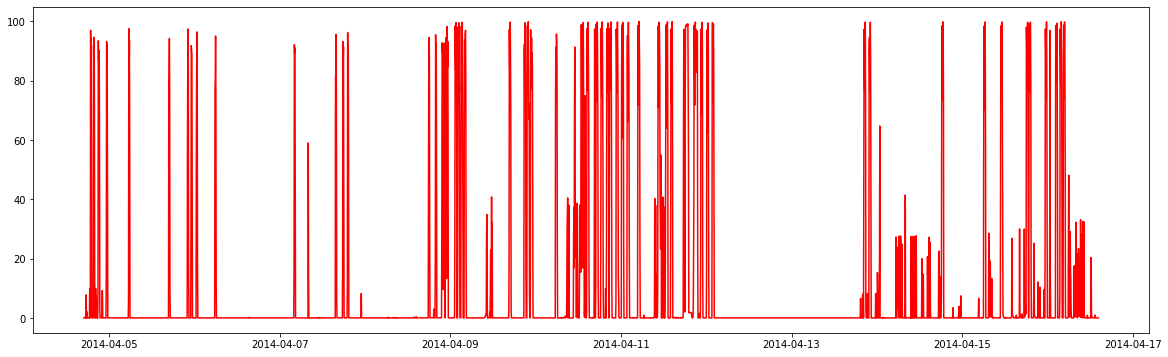

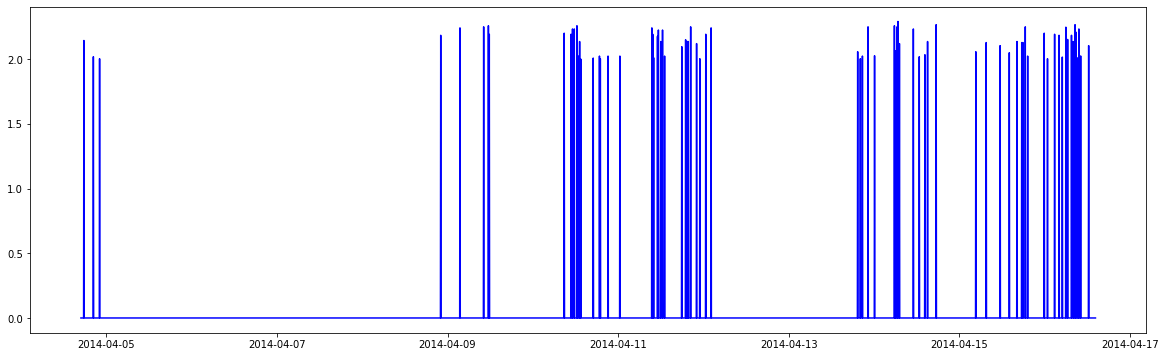

In [133]:
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_scores_after_aggregate.to_pd(), 'b')


In [134]:

evaluateModel(test_labels, test_scores_after_aggregate)

Precision: 0.0135, Recall: 1.0000, F1: 0.0267
Mean Time To Detect: 0 days 04:35:00


### Isolation Tree with data preprocess (use some functions from SalesForce Merlion)

In [135]:
from merlion.transform.moving_average import DifferenceTransform
from merlion.transform.sequence import TransformSequence
from merlion.transform.resample import Shingle
from sklearn.ensemble import IsolationForest
from merlion.utils import UnivariateTimeSeries, TimeSeries

_default_transform = TransformSequence([DifferenceTransform(), Shingle(size=2, stride=1)])

#_default_transform = TransformSequence([Shingle(size=2, stride=1)])

_default_transform.train(train_data)

#train_data needs to transform
train_data_ = _default_transform(train_data)

outlier_fraction = 'auto'

times, train_values = zip(*train_data_.align())
train_values = np.asarray(train_values)

clf = IsolationForest(n_estimators=100, max_samples="auto", random_state=0, contamination=outlier_fraction)
clf.fit(train_values)

IsolationForest(random_state=0)

In [136]:
train_scores = -clf.score_samples(train_values)
times, train_values = zip(*train_data_.align())
train_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, train_scores)})

test_data_ = _default_transform(test_data)
times_test, test_values = zip(*test_data_.align())
test_values = np.asarray(test_values)

test_scores = -clf.score_samples(test_values)

times, test_values = zip(*test_data_.align())
test_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, test_scores)})

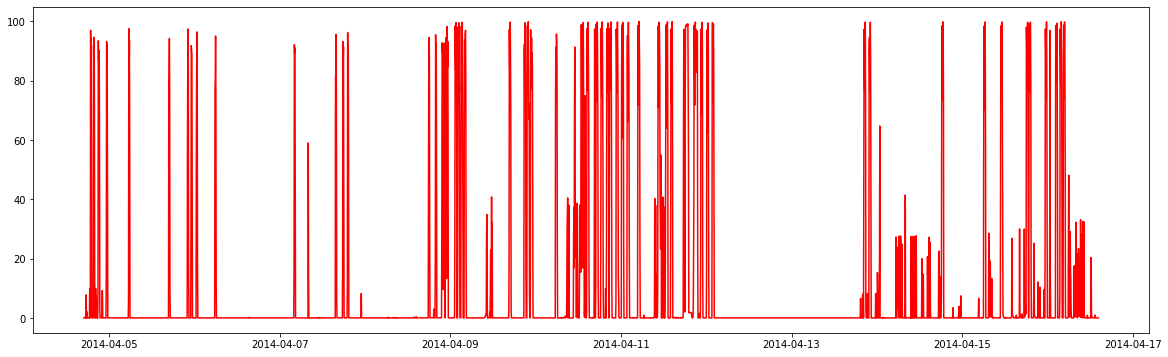

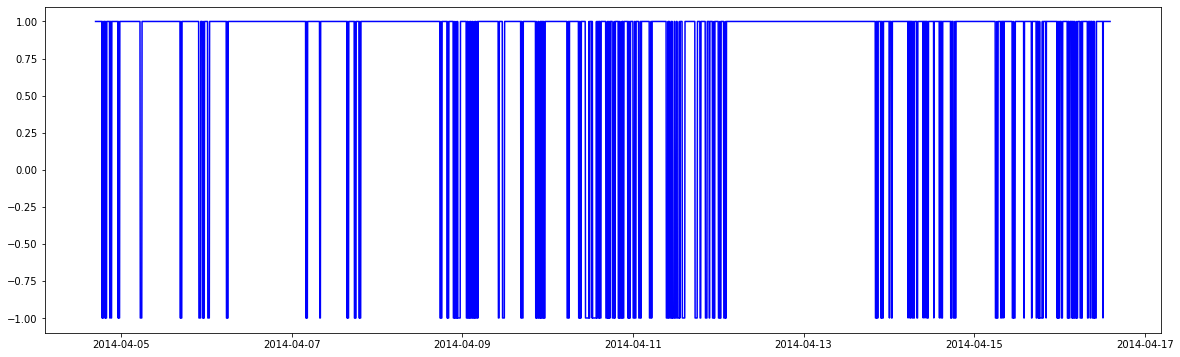

In [141]:
# if without custom label function, the labels would be very annoying
result = clf.predict(test_values)
result

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
# if DifferenceTransform is enabled in preprocess
plt.plot(test_data.to_pd().index[:-1], result, 'b')
# if DifferenceTransform is not enabled in preprocess
#plt.plot(test_data.to_pd().index, result, 'b')

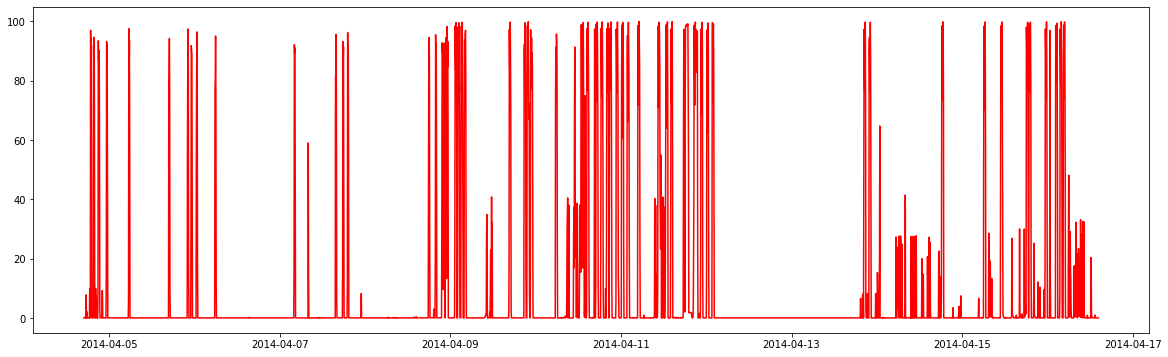

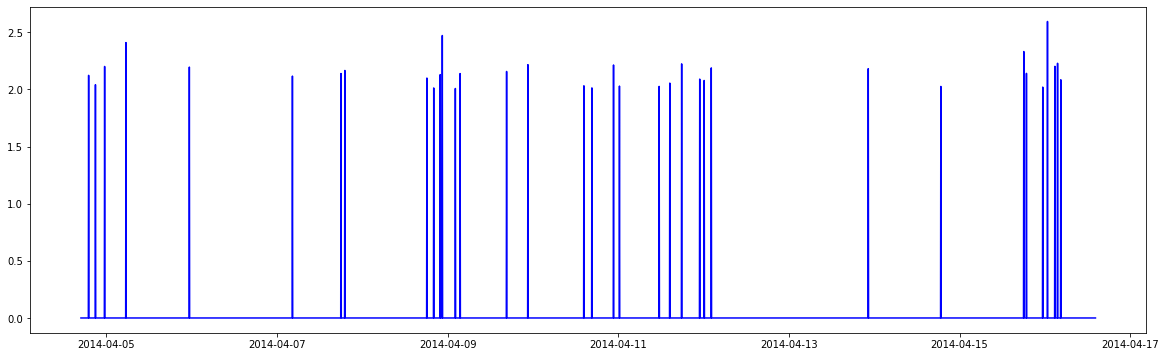

In [143]:
# with labels being aggregated, the results would be look more clean
from merlion.post_process.calibrate import AnomScoreCalibrator
from merlion.post_process.threshold import AggregateAlarms

max_score = 1.0
calibrator = AnomScoreCalibrator(max_score=max_score)
calibrator.train(anomaly_scores=train_scores)
train_scores_after_calibrator = calibrator(train_scores)
test_scores_after_calibrator = calibrator(test_scores)

custom_threshold = AggregateAlarms(alm_threshold=2, 
                                   abs_score=True,
                                   min_alm_in_window = 2,
                                   alm_window_minutes = 30,
                                   alm_suppress_minutes = 30)
custom_threshold.train(anomaly_scores=train_scores_after_calibrator)
test_scores_after_aggregate = custom_threshold(test_scores_after_calibrator)

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
# if DifferenceTransform is enabled in preprocess
plt.plot(test_data.to_pd().index[:-1], test_scores_after_aggregate.to_pd(), 'b')
# if DifferenceTransform is not enabled in preprocess
# plt.plot(test_data.to_pd().index, test_scores_after_aggregate.to_pd(), 'b')


In [144]:
evaluateModel(test_labels, test_scores_after_aggregate)

Precision: 0.0357, Recall: 1.0000, F1: 0.0690
Mean Time To Detect: 0 days 00:45:00


Improvement in precision and F1 scores

### Isolation Tree using SalesForce Merlion

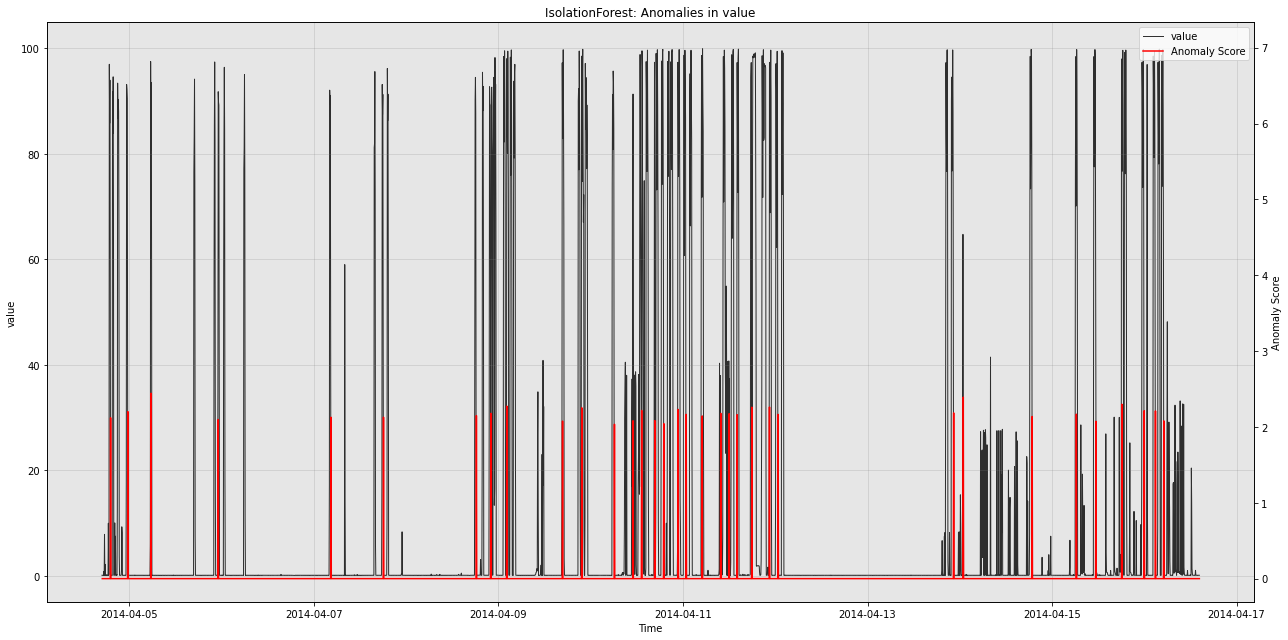

In [145]:
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig
from merlion.post_process.threshold import AggregateAlarms

config = IsolationForestConfig(threshold=AggregateAlarms(alm_threshold=2))
model_merlion  = IsolationForest(config)

train_scores_merlion = model_merlion.train(train_data=train_data, anomaly_labels=None)

scores_merlion = model_merlion.get_anomaly_score(test_data)
labels_merlion = model_merlion.get_anomaly_label(test_data)

fig, ax = model_merlion.plot_anomaly(
    time_series=test_data,
    filter_scores=True, 
    plot_time_series_prev=True,
    figsize=(1800,900))

plt.show()
print()

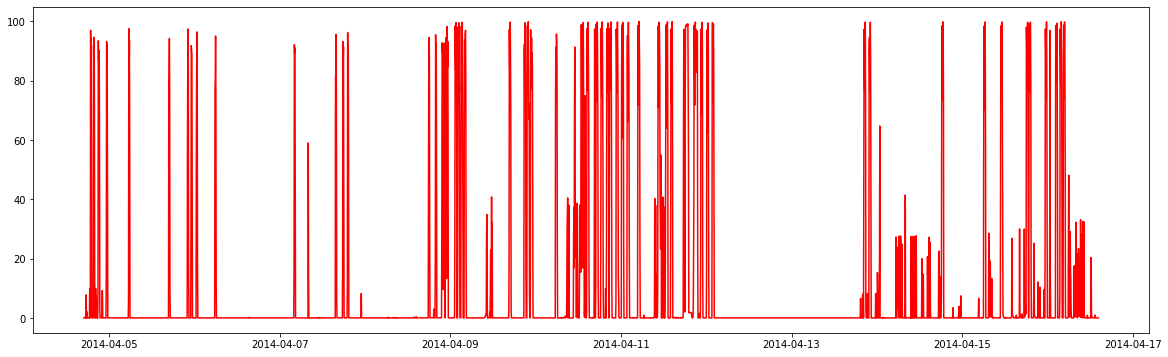

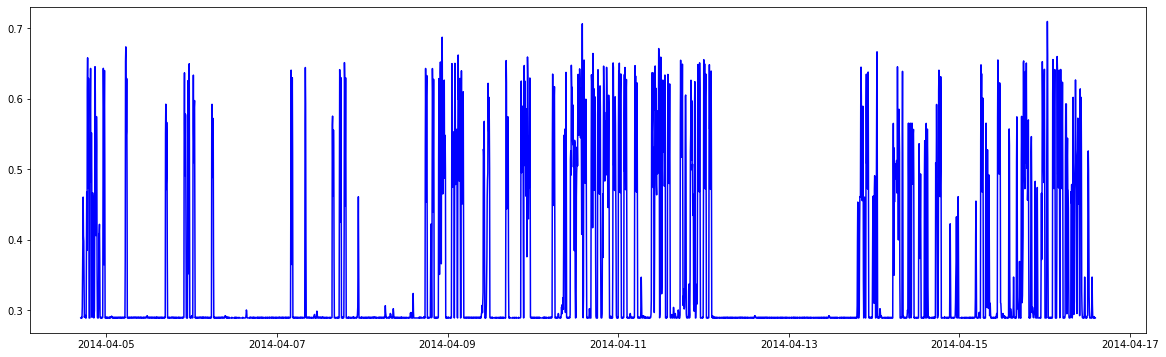

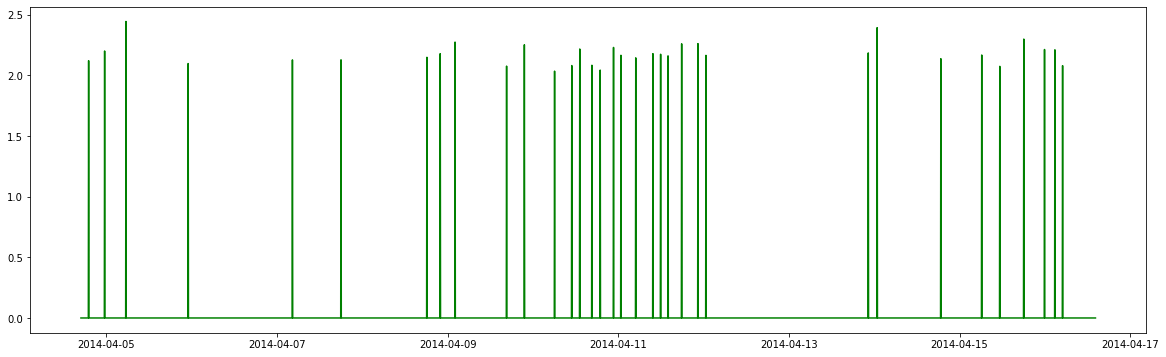

In [148]:
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[:-1], scores_merlion.to_pd(), 'b')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[:-1], labels_merlion.to_pd(), 'g')

In [149]:

evaluateModel(test_labels, labels_merlion)

Precision: 0.0333, Recall: 1.0000, F1: 0.0645
Mean Time To Detect: 0 days 00:45:00


## Real traffic data 

In [416]:
from sklearn.ensemble import IsolationForest
time_series, metadata = NAB(subset="realTraffic")[3]

from merlion.utils import TimeSeries

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

Time series /Users/I853328/Desktop/Merlion/data/nab/realTraffic/occupancy_t4013.csv (index 3) has timestamp duplicates. Kept first values.
Time series /Users/I853328/Desktop/Merlion/data/nab/realTraffic/speed_t4013.csv (index 6) has timestamp duplicates. Kept first values.


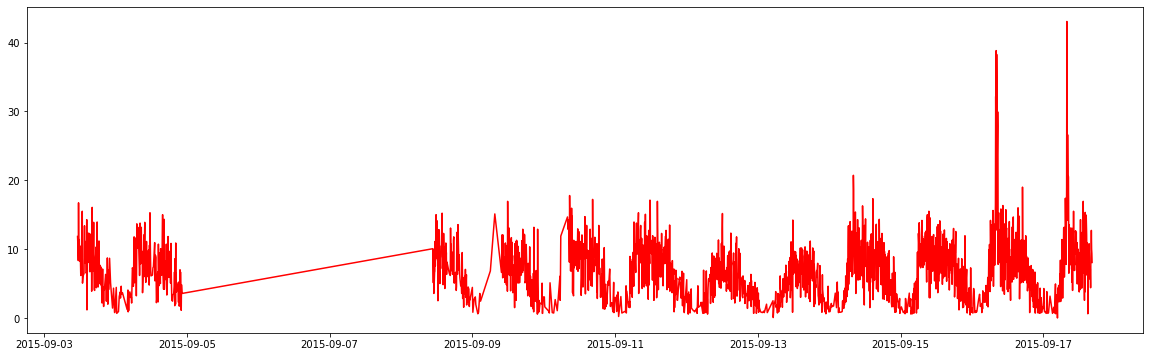

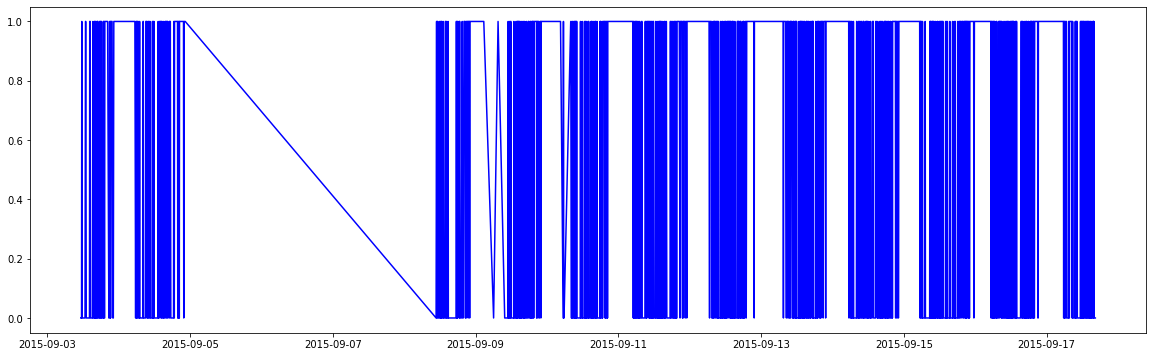

In [417]:
outlier_fraction = 'auto'

clf = IsolationForest(n_estimators=50, max_samples="auto", random_state=0, contamination=outlier_fraction, bootstrap=True,)

clf.fit(train_data.to_pd()['value'].values.reshape(len(train_data),1))

result = clf.predict(test_data.to_pd()['value'].values.reshape(len(test_data),1))
result = pd.DataFrame( { 'anomaly' : [ 0. if i==1 else 1. for i in list(result) ], 
                        }, index = test_data.to_pd().index)
#pd.DataFrameresult= train_data.to_pd().index
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, result, 'b')

In [418]:
from merlion.evaluate.anomaly import TSADMetric
p = TSADMetric.Precision.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
r = TSADMetric.Recall.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
f1 = TSADMetric.F1.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=test_labels, predict=TimeSeries.from_pd(result))
print(f"Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}\n"
       f"Mean Time To Detect: {mttd}")



Precision: 0.0022, Recall: 1.0000, F1: 0.0043
Mean Time To Detect: 0 days 00:00:00


### Custom label function

In [188]:
train_scores = -clf.score_samples(train_data.to_pd()['value'].values.reshape(len(train_data),1))
times = train_data.to_pd().index
train_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, train_scores)})

test_scores = -clf.score_samples(test_data.to_pd()['value'].values.reshape(len(test_data),1))
times = test_data.to_pd().index
test_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, test_scores)})

In [189]:
from merlion.post_process.calibrate import AnomScoreCalibrator

max_score = 1.0
calibrator = AnomScoreCalibrator(max_score=max_score)
calibrator.train(anomaly_scores=train_scores)
train_scores_after_calibrator = calibrator(train_scores)
test_scores_after_calibrator = calibrator(test_scores)

calibrator

AnomScoreCalibrator(abs_score=True, anchors=[(0.46173681821458956, 0.0), (0.4811138580468263, 0.5), (0.5171076098556359, 1.0), (0.5517940636695012, 1.5), (0.6433885188014884, 2.0), (1.0, 5.0)], max_score=1.0)

In [200]:
from merlion.post_process.threshold import AggregateAlarms

custom_threshold = AggregateAlarms(alm_threshold=2.5, 
                                   abs_score=True,
                                   min_alm_in_window = 2,
                                   alm_window_minutes = 10,
                                   alm_suppress_minutes = 10)
custom_threshold.train(anomaly_scores=train_scores_after_calibrator)
test_scores_after_aggregate = custom_threshold(test_scores_after_calibrator)

custom_threshold

AggregateAlarms(abs_score=True, alm_suppress_minutes=10, alm_threshold=2.5, alm_window_minutes=10, min_alm_in_window=2)

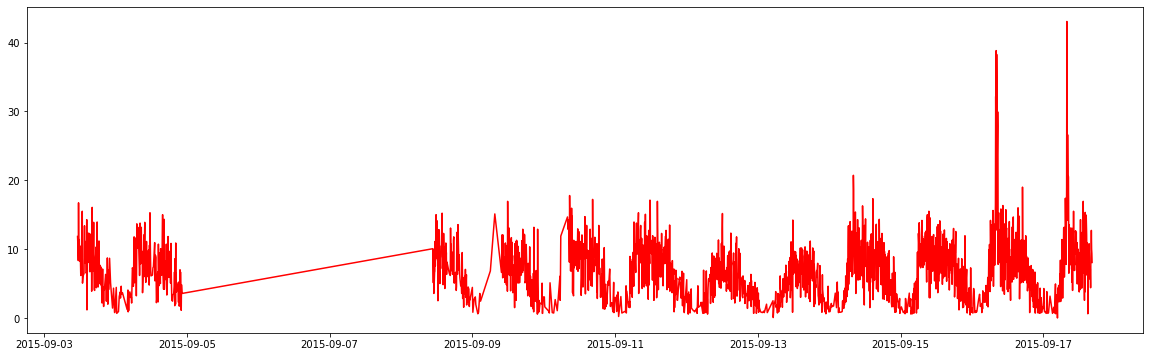

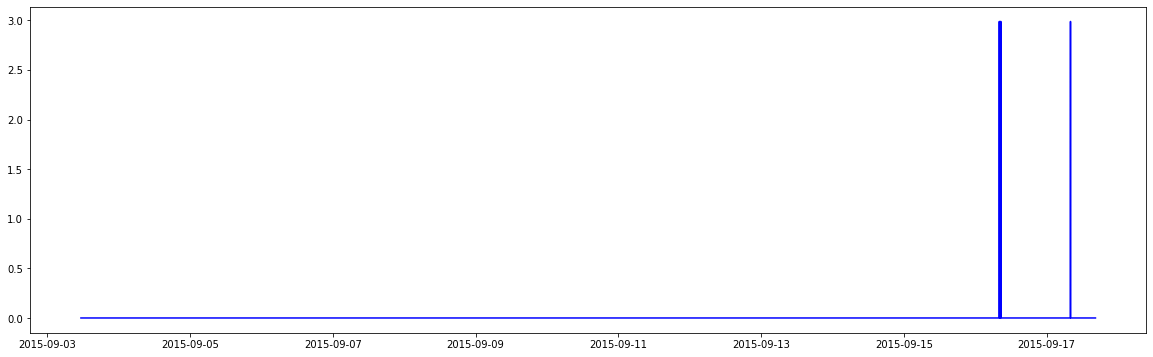

In [201]:
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_scores_after_aggregate.to_pd(), 'b')


In [202]:

evaluateModel(test_labels, test_scores_after_aggregate)

Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Mean Time To Detect: 0 days 07:22:30


### Isolation Tree with data preprocess (use some functions from SalesForce Merlion)

In [203]:
from merlion.transform.moving_average import DifferenceTransform
from merlion.transform.sequence import TransformSequence
from merlion.transform.resample import Shingle
from sklearn.ensemble import IsolationForest
from merlion.utils import UnivariateTimeSeries, TimeSeries

_default_transform = TransformSequence([DifferenceTransform(), Shingle(size=2, stride=1)])

#_default_transform = TransformSequence([Shingle(size=2, stride=1)])

_default_transform.train(train_data)

#train_data needs to transform
train_data_ = _default_transform(train_data)

outlier_fraction = 'auto'

times, train_values = zip(*train_data_.align())
train_values = np.asarray(train_values)

clf = IsolationForest(n_estimators=100, max_samples="auto", random_state=0, contamination=outlier_fraction)
clf.fit(train_values)

IsolationForest(random_state=0)

In [204]:
train_scores = -clf.score_samples(train_values)
times, train_values = zip(*train_data_.align())
train_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, train_scores)})

test_data_ = _default_transform(test_data)
times_test, test_values = zip(*test_data_.align())
test_values = np.asarray(test_values)

test_scores = -clf.score_samples(test_values)

times, test_values = zip(*test_data_.align())
test_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, test_scores)})

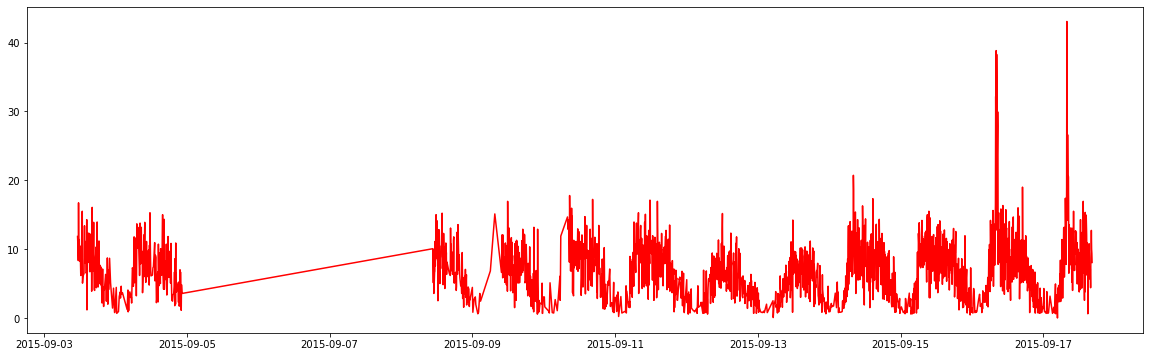

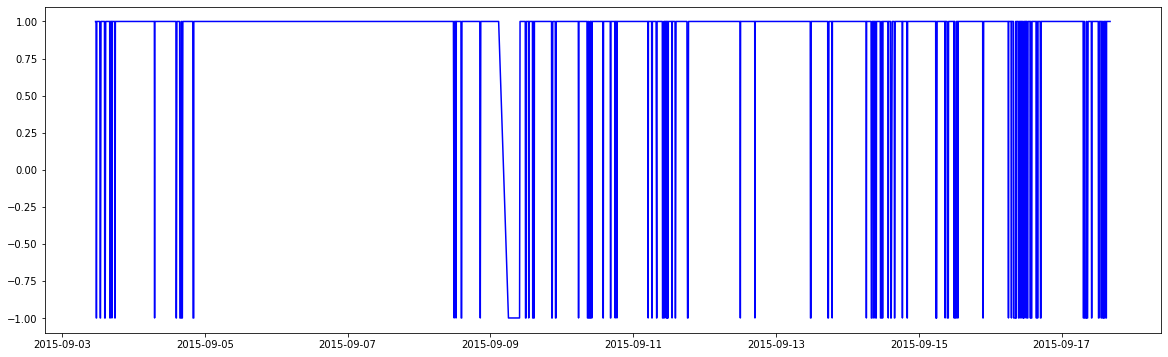

In [205]:
# if without custom label function, the labels would be very annoying
result = clf.predict(test_values)
result

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
# if DifferenceTransform is enabled in preprocess
plt.plot(test_data.to_pd().index[:-1], result, 'b')
# if DifferenceTransform is not enabled in preprocess
#plt.plot(test_data.to_pd().index, result, 'b')

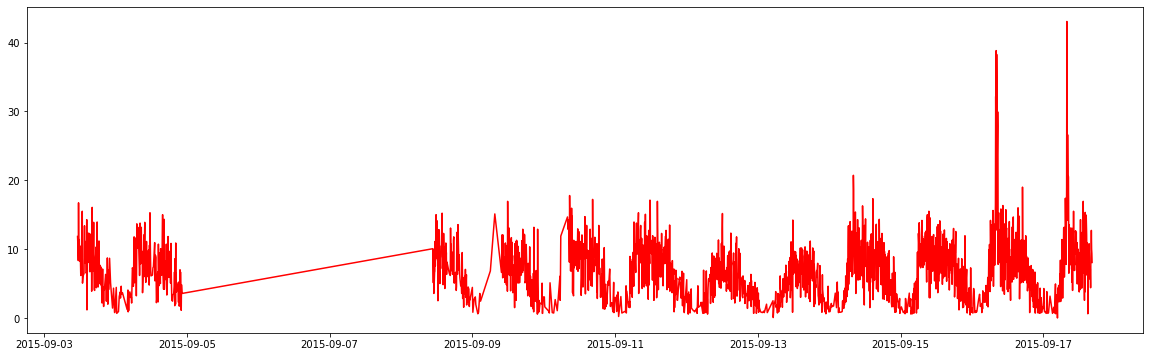

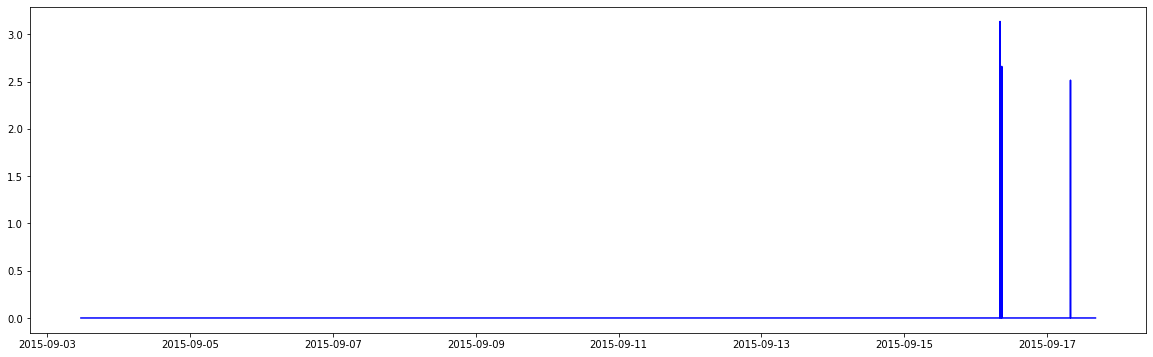

In [209]:
# with labels being aggregated, the results would be look more clean
from merlion.post_process.calibrate import AnomScoreCalibrator
from merlion.post_process.threshold import AggregateAlarms

max_score = 1.0
calibrator = AnomScoreCalibrator(max_score=max_score)
calibrator.train(anomaly_scores=train_scores)
train_scores_after_calibrator = calibrator(train_scores)
test_scores_after_calibrator = calibrator(test_scores)

custom_threshold = AggregateAlarms(alm_threshold=2.5, 
                                   abs_score=True,
                                   min_alm_in_window = 2,
                                   alm_window_minutes = 10,
                                   alm_suppress_minutes = 10)
custom_threshold.train(anomaly_scores=train_scores_after_calibrator)
test_scores_after_aggregate = custom_threshold(test_scores_after_calibrator)

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
# if DifferenceTransform is enabled in preprocess
plt.plot(test_data.to_pd().index[:-1], test_scores_after_aggregate.to_pd(), 'b')
# if DifferenceTransform is not enabled in preprocess
# plt.plot(test_data.to_pd().index, test_scores_after_aggregate.to_pd(), 'b')


In [210]:
evaluateModel(test_labels, test_scores_after_aggregate)

Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Mean Time To Detect: 0 days 07:30:00


Improvement in precision and F1 scores

### Isolation Tree using SalesForce Merlion

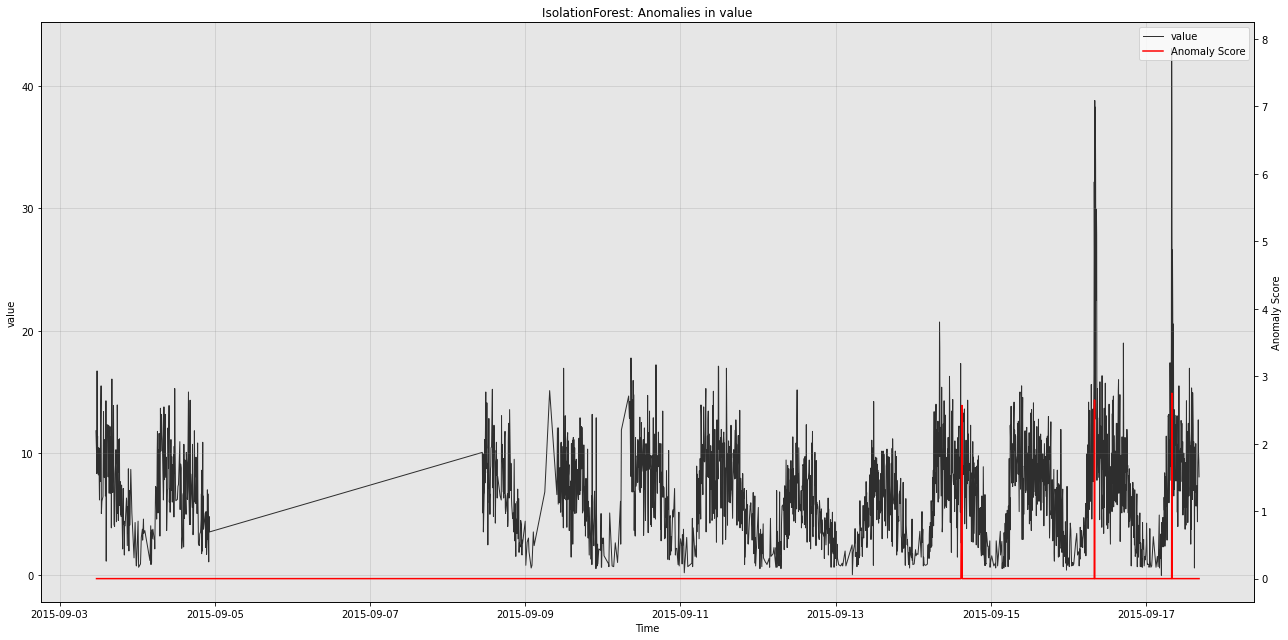

In [419]:
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig
from merlion.post_process.threshold import AggregateAlarms

config = IsolationForestConfig(threshold=AggregateAlarms(alm_threshold=2.5))
model_merlion  = IsolationForest(config)

train_scores_merlion = model_merlion.train(train_data=train_data, anomaly_labels=None)

scores_merlion = model_merlion.get_anomaly_score(test_data)
labels_merlion = model_merlion.get_anomaly_label(test_data)

fig, ax = model_merlion.plot_anomaly(
    time_series=test_data,
    filter_scores=True, 
    plot_time_series_prev=True,
    figsize=(1800,900))

plt.show()
print()

In [421]:
train_data

                     value
2015-09-01 11:30:00  13.56
2015-09-01 11:35:00   8.33
2015-09-01 11:40:00  11.78
2015-09-01 11:55:00  15.28
2015-09-01 12:00:00  10.06
...                    ...
2015-09-03 10:46:00  13.61
2015-09-03 10:51:00  10.56
2015-09-03 10:56:00   7.22
2015-09-03 11:06:00  12.67
2015-09-03 11:11:00  10.72

[375 rows x 1 columns]

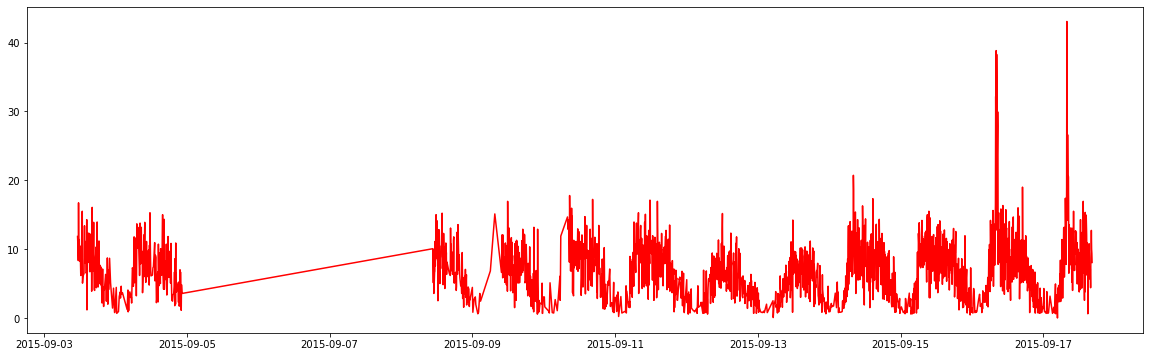

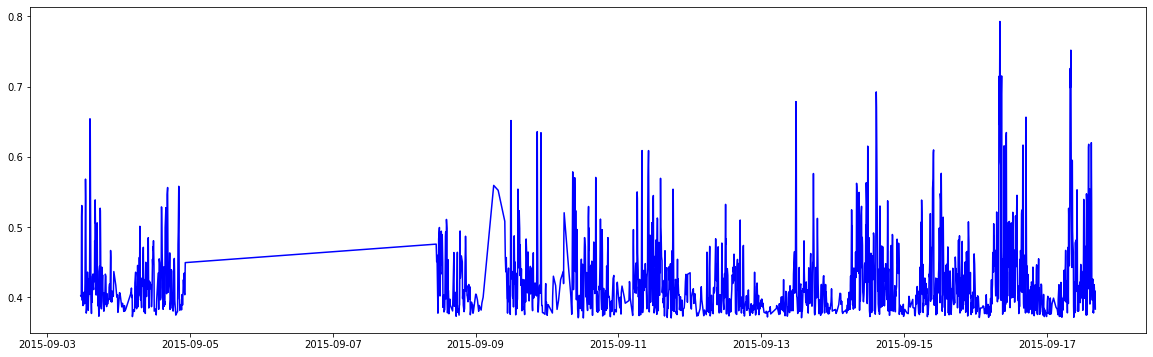

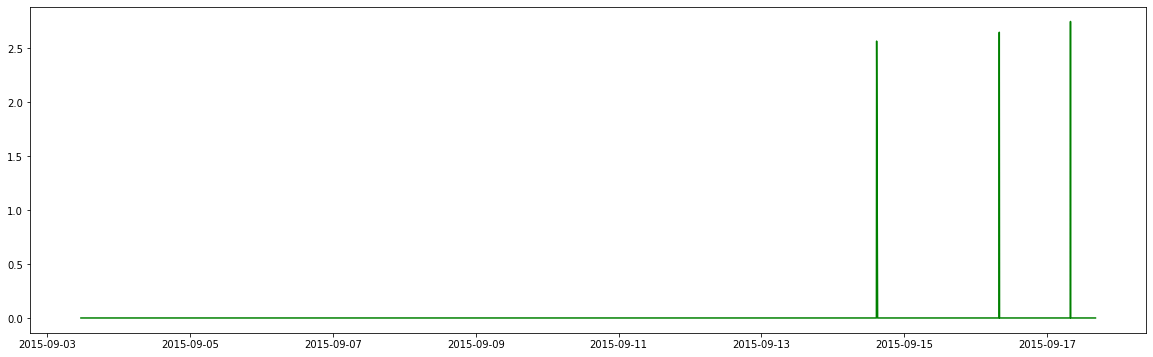

In [213]:
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[:-1], scores_merlion.to_pd(), 'b')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[:-1], labels_merlion.to_pd(), 'g')

In [214]:

evaluateModel(test_labels, labels_merlion)

Precision: 0.6667, Recall: 1.0000, F1: 0.8000
Mean Time To Detect: 0 days 07:22:30


## Conclusion

- Models do decent when threshold levels are set to correct values
- We definitely need LABELED REAL DATA for VALIDATION SET(better if we can do multi fold cross validation) to come up with right set of parameters for production
- There will be trade off b/w precision and recall -> we need to see what is more important for SRE, dev teams and business. F1 score could be a good starting point. And then we can iterate over it.